<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/TEPQOCSVM_Large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Train_large.csv')

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Test_large.csv')

# Convert training features to numpy array and select 100 samples
train_features = train_df.to_numpy()

test_features= test_df.to_numpy()

# Create target arrays for training and testing data
test_target = np.concatenate((np.zeros(500), np.ones(25)))

# Ensure arrays are of size samples*8 (assuming 8 is the number of features)
print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of test_target: {test_target.shape}")

Shape of train_features: (4500, 11)
Shape of test_features: (525, 11)
Shape of test_target: (525,)


In [2]:
# ---- Install deps (Colab/Python 3.12 friendly) ----
!pip -q install "qiskit==1.2.4" "qiskit-machine-learning==0.8.4" "scikit-learn==1.6.1" numpy pandas matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 28.3 MB/s eta 0:00:00


Raw shapes -> train: (4500, 11)  test: (525, 11)
Using 6 features (indices): [10, 9, 8, 7, 6, 5]
Kernel train subset: (200, 6)
Computing quantum kernel matrices...


/tmp/ipython-input-157745133.py:61: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler  = Sampler()  # fast simulator
/tmp/ipython-input-157745133.py:62: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler=sampler)


Kernel shapes: (200, 200) (525, 200)

=== ROC-AUC (quantum semi-supervised) = 0.5138 ===
Confusion matrix [[TN, FP],[FN, TP]]:
 [[294 206]
 [ 11  14]]
Precision=0.064  Recall=0.560  F1=0.114  (thr=0.0775)


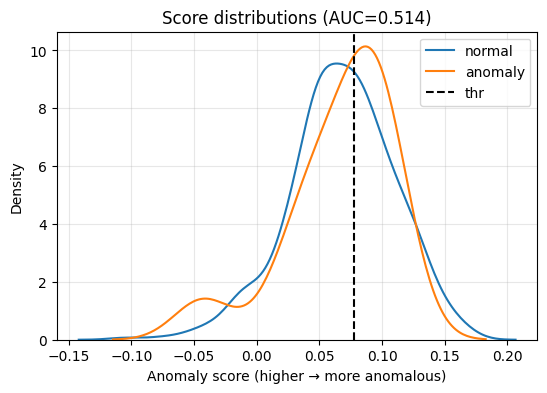

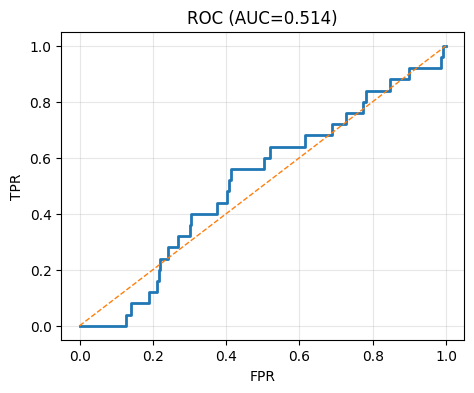


Tip: If AUC < 0.6, try REPS=3, NU in [0.02, 0.12], TRAIN_SUBSET≈1000–1500, or N_FEATS=8.


In [4]:
# ===============================================================
# Quantum Semi-Supervised Anomaly Detection (Qiskit + OCSVM)
# FidelityQuantumKernel trained on normals only; evaluates on test
# ===============================================================

# ---- Tunables (start here) ----
N_FEATS = 6          # try 6–8 for speed/accuracy; set 11 to use all features (slower)
TRAIN_SUBSET = 200   # number of normal training points used for the kernel (e.g., 600–1200)
REPS = 2             # circuit depth (1–3). Higher = more expressive, slower.
NU = 0.08            # One-Class SVM nu (approx. fraction of training outliers); tune 0.02–0.15


import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# ---------------------------
# 1) Load data (your paths)
# ---------------------------
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Train_large.csv')  # 4500 normals
test_df  = pd.read_csv('/content/drive/MyDrive/QMLIIOT/TEP9Test_large.csv')   # 500 normals + 25 anomalies

X_train_raw = train_df.to_numpy().astype(np.float32)   # (4500, 11)
X_test_raw  = test_df.to_numpy().astype(np.float32)    # (525, 11)
y_test      = np.concatenate((np.zeros(500), np.ones(25))).astype(int)

print("Raw shapes -> train:", X_train_raw.shape, " test:", X_test_raw.shape)

# ---------------------------
# 2) Scale on normals only
# ---------------------------
scaler = StandardScaler().fit(X_train_raw)
Xn = scaler.transform(X_train_raw).astype(np.float32)
Xt = scaler.transform(X_test_raw).astype(np.float32)

# ---------------------------
# 3) Simple feature selection (no PCA): top-variance features
# ---------------------------
vars_ = Xn.var(axis=0)
feat_idx = np.argsort(vars_)[::-1][:N_FEATS]
Xn = Xn[:, feat_idx]
Xt = Xt[:, feat_idx]
print(f"Using {N_FEATS} features (indices): {feat_idx.tolist()}")

# ---------------------------
# 4) Subsample normals for kernel training (speed)
# ---------------------------
TRAIN_SUBSET = min(TRAIN_SUBSET, len(Xn))
Xn_sub = Xn[:TRAIN_SUBSET]
print(f"Kernel train subset: {Xn_sub.shape}")

# ---------------------------
# 5) Quantum kernel (PauliFeatureMap + Sampler)
# ---------------------------
feature_map = PauliFeatureMap(feature_dimension=N_FEATS, reps=REPS, entanglement='linear')
sampler  = Sampler()  # fast simulator
fidelity = ComputeUncompute(sampler=sampler)
kernel   = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

print("Computing quantum kernel matrices...")
K_train = kernel.evaluate(x_vec=Xn_sub)
K_test  = kernel.evaluate(x_vec=Xt, y_vec=Xn_sub)
print("Kernel shapes:", K_train.shape, K_test.shape)

# ---------------------------
# 6) One-Class SVM (semi-supervised; train on normals only)
# ---------------------------
ocsvm = OneClassSVM(kernel='precomputed', nu=NU, gamma='auto')
ocsvm.fit(K_train)

# Anomaly scores: larger = more anomalous
scores = -ocsvm.decision_function(K_test).ravel()

# ---------------------------
# 7) Metrics & quick plots
# ---------------------------
auc_roc = roc_auc_score(y_test, scores)
print(f"\n=== ROC-AUC (quantum semi-supervised) = {auc_roc:.4f} ===")

# Optional: choose a threshold by Youden J on ROC for a confusion matrix
fpr, tpr, thr = roc_curve(y_test, scores)
j_idx = np.argmax(tpr - fpr)
best_thr = thr[j_idx] if j_idx < len(thr) else np.median(scores)
y_pred = (scores >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)
print(f"Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  (thr={best_thr:.4f})")

# Distributions
plt.figure(figsize=(6.2,4))
sns.kdeplot(scores[y_test==0], label='normal'); sns.kdeplot(scores[y_test==1], label='anomaly')
plt.axvline(best_thr, ls='--', c='k', label='thr')
plt.xlabel("Anomaly score (higher → more anomalous)"); plt.title(f"Score distributions (AUC={auc_roc:.3f})")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# ROC
plt.figure(figsize=(5.2,4))
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--',lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (AUC={auc_roc:.3f})")
plt.grid(alpha=0.3); plt.show()

print("\nTip: If AUC < 0.6, try REPS=3, NU in [0.02, 0.12], TRAIN_SUBSET≈1000–1500, or N_FEATS=8.")
